In [1]:
import msrvxc
import numpy as np
import pickle

import matplotlib.pyplot as plt
from tqdm import tqdm

from astroquery.sdss import SDSS
from astroquery.gaia import Gaia

In [2]:
#wvl, raw_values, interp_bosz, interp_bosz_norm = msrvxc.build.build_bosz_grid(wl_range = [3600, 9000])

In [3]:
#with open('grids/interp_bosz_norm.pkl', 'wb') as f:
#    pickle.dump(interp_bosz_norm, f)
#    
#with open('grids/interp_bosz.pkl', 'wb') as f:
#    pickle.dump(interp_bosz, f)
#    
#np.save('grids/wavl.npy',wvl)

In [4]:
with open('grids/interp_bosz.pkl', 'rb') as f:
    interp_bosz = pickle.load(f)
    
with open('grids/interp_bosz_norm.pkl', 'rb') as f:
    interp_bosz_norm = pickle.load(f)
    
wvl = np.load('grids/wavl.npy')

In [5]:
print(len(wvl))

18326


In [6]:
params = (4999.848788360524,
3.812724027560155,
0.4084144628961131,
0.5593886093528815)

print(len(interp_bosz_norm(params)))

18326


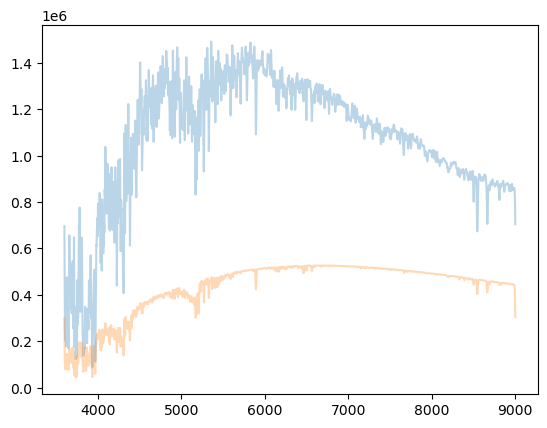

In [7]:


plt.plot(wvl, interp_bosz(params), alpha = 0.3)
plt.plot(wvl, interp_bosz((4213, 4.6, -2.3, 0)), alpha = 0.3)

In [8]:
import msrvxc


#params, rvgrid, cc = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wvl, interp_bosz_norm((4213, 4.1, -2.3, -40)))



In [9]:
#fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
#samples = sampler.get_chain()
#labels = ["Teff", "logg", "Z", "rv"]
#for i in range(ndim):
#    ax = axes[i]
#    ax.plot(samples[:, :, i], "k", alpha=0.3)
#    ax.set_xlim(0, len(samples))
#    ax.set_ylabel(labels[i])
#    ax.yaxis.set_label_coords(-0.1, 0.5)
#
#axes[-1].set_xlabel("step number");

In [10]:
#flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
#print(flat_samples.shape)

In [11]:
#import corner
#
#fig = corner.corner(
#    flat_samples, labels=labels, truths=[4213, 4.1, -2.3, 0]
#);

In [12]:
#X = np.median(flat_samples,axis=0)
#T, logg, Z, rv = X[:4]
#
#print(T, logg, Z, rv)

In [13]:
from astropy.table import Table, vstack

catalog = Table.read('../gravitational-redshift/data/00_raw.fits')
dat = Table()

dat['sourceid'] = catalog['ms_source_id']

In [14]:
GAIA_ADQL = """SELECT gaia.radial_velocity, gaia.radial_velocity_error, sdss.original_ext_source_id as bestobjid
    FROM gaiadr3.gaia_source as gaia
    JOIN gaiaedr3.sdssdr13_best_neighbour as sdss
    ON gaia.source_id = sdss.source_id      
    WHERE gaia.radial_velocity is not null AND
    gaia.rv_template_teff BETWEEN 2000 AND 7000 AND
    gaia.rv_template_logg BETWEEN 2.5 AND 5"""

job1 = Gaia.launch_job(GAIA_ADQL,dump_to_file=False)
d1 = job1.get_results()

In [15]:
stardats = []
iters = len(dat) // 100

for i in tqdm(range(iters)):
    SDSS_QUERY = """select bestObjID as bestobjid, plate, mjd, fiberID, subClass
        from dbo.SpecObjAll
        where bestObjID in {}""".format(tuple(d1['bestobjid'][100*i:100*i+100]))
    try:
        f = SDSS.query_sql(SDSS_QUERY)
        if f is not None:
            stardats.append(SDSS.query_sql(SDSS_QUERY))
    except:
        pass
spec = vstack(stardats)

  0%|                                                                                            | 0/44 [00:00<?, ?it/s]/home/arseneau/anaconda3/lib/python3.9/site-packages/astroquery/sdss/core.py:874: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  arr = np.atleast_1d(np.genfromtxt(io.BytesIO(response.content),
100%|██████████████████████████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 403.14it/s]


In [16]:
from astropy.table import Table, join

data = join(spec, d1, keys = 'bestobjid')
data

bestobjid,plate,mjd,fiberID,subClass,radial_velocity,radial_velocity_error
,,,,,km / s,km / s
int64,int64,int64,int64,bytes2,float32,float32
1237651273503277100,2383,53800,314,G2,-348.5674,4.026336
1237655107830677507,2384,53763,257,G0,-321.1911,8.829859
1237662336798228589,2180,54613,299,G2,-464.6429,4.596619
1237663229609705587,2179,53555,350,F5,-377.2304,5.3083215
1237663269333368890,2802,54326,350,F5,-321.13217,9.141074
1237663273630498915,2179,53555,465,G0,-317.14438,8.452468
1237665356164366449,2176,54243,36,F9,-311.8417,3.2247012
1237665582189052021,2253,54551,282,F9,-362.96664,7.216066


In [17]:
from Payne import utils as payne_utils

c_kms = 2.99792458e5 # speed of light in km/s

def simulate_spec(interpolator, interp_wvl, wl, params):
    teff, logg, Z, rv = (params['teff'], params['logg'], params['z'], params['RV'])
    
    wl = wl * np.sqrt((1 - rv/c_kms)/(1 + rv/c_kms))
    
    return payne_utils.smoothing.smoothspec(wl, np.interp(wl, interp_wvl, interpolator( (teff, logg, Z, 0) )), resolution = 3000, smoothtype="R")

<Parameter 'teff', value=5749.180957397548, bounds=[3500:7000]>
-356.0
-356.10952773677656
-356.0
RV: -356.1 (initially -356.1) 
 Teff: 5749.180957 
 logg 2.500
<Parameter 'RV', value=-356.1095277367765, bounds=[-1500:1500]>


Text(0, 0.5, 'chi2')

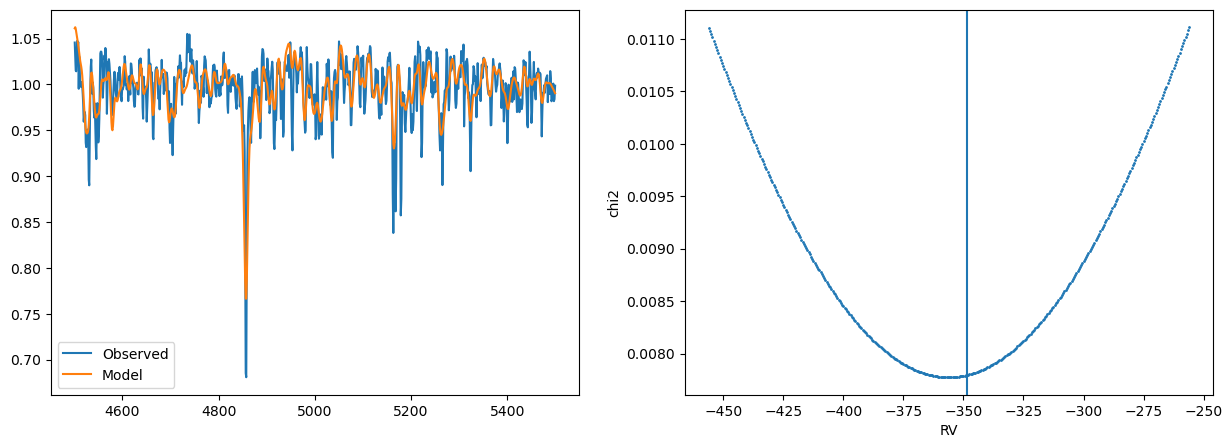

In [18]:
i = 0

spec = SDSS.get_spectra(plate=data['plate'][i], fiberID=data['fiberID'][i], mjd=data['mjd'][i])[0]

wl = (10**spec[1].data['loglam'])
fl = (spec[1].data['flux'])
ivar = (spec[1].data['ivar'])

mask = (4500 < wl)*(wl < 5500)

init.params, rv, e_rv, rvgrid, cc = msrvxc.fit.fit_rv(interp_bosz_norm, wvl, wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], ivar[mask])

print("RV: {:3.1f} (initially {:3.1f}) \n Teff: {:4f} \n logg {:2.3f}".format(res.params['RV'].value, rv_init, res.params['teff'].value, res.params['logg'].value))
print(res.params['RV'])

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)

res.params['RV'].value = rv

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

plt.legend()

plt.subplot(1,2,2)

plt.scatter(rvgrid, cc, s = 1)
plt.axvline(x=data['radial_velocity'][i])

plt.xlabel('RV')
plt.ylabel('chi2')

Parameters([('teff', <Parameter 'teff', value=5749.180957397548 (fixed), bounds=[3500:7000]>), ('logg', <Parameter 'logg', value=2.500000000220576 (fixed), bounds=[2.5:5]>), ('z', <Parameter 'z', value=-0.8217120979341206 (fixed), bounds=[-2.5:0.5]>), ('RV', <Parameter 'RV', value=-348.5674, bounds=[-1500:1500]>)])


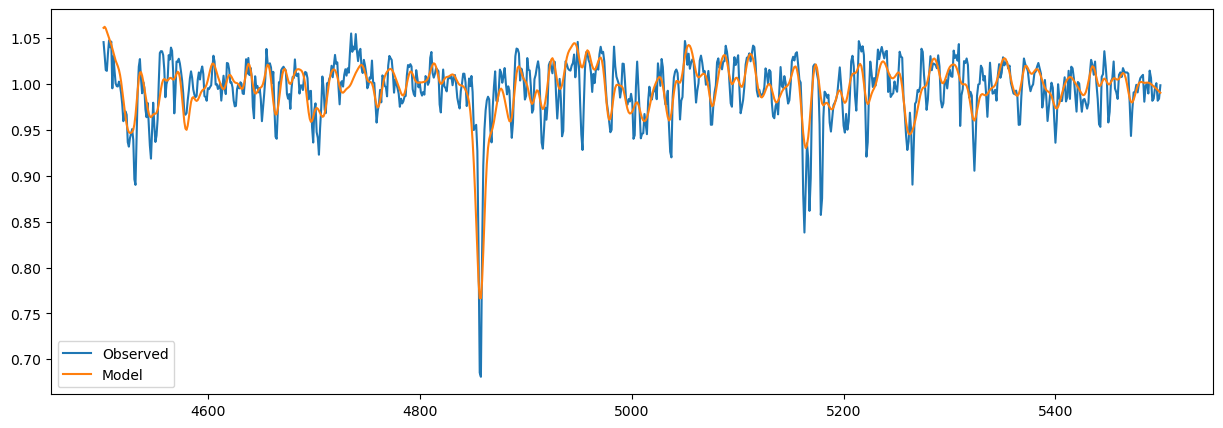

In [19]:
plt.figure(figsize = (15,5))

mask = (4500 < wl)*(wl < 5500)

plt.plot(wl[mask], msrvxc.utils.continuum_normalize(wl, fl)[1][mask], label = 'Observed')
plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model')

res.params['RV'].value = -348.5674

print(res.params)

#plt.plot(wl[mask], simulate_spec(interp_bosz_norm, wvl, wl, res.params)[mask], alpha = 1, label = 'Model With RV Forced Correct')

plt.legend()